# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


## TD10 : Mélanges de lois : Classification du rayon des tumeurs

Les données du concours A2020 sont utilisées.

## Contexte

Une tumeur est un groupe de cellules anormales qui forment une masse. Les tumeurs se développent et se comportent différemment, selon qu’elles soient cancéreuses (malignes), non cancéreuses (bénignes). Le but du concours était de prédire si une tumeur est bénigne (0) ou maligne (1) en fonction des caractéristiques suivantes récoltées par imagerie médicale : 

- radius : distance moyenne entre le centre de la tumeur et son périmètre ;
- texture : écart-type des niveaux de gris représentant l'image de la tumeur ;
- perimeter : périmètre de la tumeur ;
- area : superficie de la tumeur ;
- smoothness : variation locale normalisée en fonction du radius (indice de rugosité) ;
- compactness : perimeter^2 / area -1 (indice de compacité) ;
- symmetry : mesure de symétrie ; 
- fractal dimension : ("coastline approximation" - 1).

Dans ce TD, nous modéliserons le rayon des tumeurs par un mélange de lois normales. On s'attend à ce que le rayon des tumeurs bénignes soient distribués selon une loi normale et que le rayon des tumeurs malignes soient distribués selon une autre loi normale. On pourra donc utiliser le mélange de lois pour classer les tumeurs à l'aide d'une seule variable : son rayon.

## Objectifs du TD

Ce TD est composé de trois exercices. Le premier exercice permet d'explorer les données. Le deuxième modélise une caractéristique des tumeurs, soit la rayon, avec un mélange de deux lois normales. Le troisième exercice permet de prédire la classe de la tumeur (bénigne ou maligne) en fonction des composantes du mélange ajusté.

Plusieurs fonctions vous sont fournies pour vous faciliter la tâche.

In [1]:
using CSV, DataFrames, Distributions, Gadfly, MLBase, Random, Statistics

In [2]:
"""
    GMM(ω::Real, μ₀::Real, σ₀::Real, μ₁::Real, σ₁::Real)

Création d'un objet de type `UnivariateMixture` de la librairie *Distributions.jl* ayant comme densité

```math
f(y) = (1-ω) ~ \\mathcal{N}( y\\mid μ₀, σ₀²) + ω ~ \\mathcal{N}( y\\mid μ₁, σ₁²)
```
"""
function GMM(ω::Real, μ₀::Real, σ₀::Real, μ₁::Real, σ₁::Real)
    
    pd = MixtureModel(Normal[ Normal(μ₀, σ₀), Normal(μ₁, σ₁)], [1-ω, ω])
    
    return pd
    
end


"""
    componentprob(mixturemodel::UnivariateMixture, y::Real; componentindex=1, logprob=false)

Calcul de la probabilité que y provienne de la composante `componentindex` du mélange `mixturemodel`.
"""
function componentprob(mixturemodel::UnivariateMixture, y::Real; componentindex=1, logprob=false)

    fc = component(mixturemodel,componentindex)
    
    lp = log(probs(mixturemodel)[componentindex]) + logpdf(fc,y) - logpdf(mixturemodel, y)
    
    if logprob
        return lp
    else
        return exp(lp)
    end
    
end

"""
    _emstep(pd::MixtureModel,y)

Réalisation d'une itération de l'algorithme EM à partir du mélange `pd` avec les données `y`.

#### Détails
La fonction met à jour les paramètres de la distribution `pd` avec les estimations améliorées.
"""
function _emstep(pd::MixtureModel,y)
    
    n = length(y)
    
    f₁ = component(pd, 2)
    ω = probs(pd)[2]
    
    lp₁ = log(ω) .+ logpdf.(f₁,y) - logpdf.(pd, y)
    p₁ = exp.(lp₁)
    
    ω̂ = sum(p₁)/n
    
    p₀ = 1 .- p₁
    
    μ̂₀ = sum( p₀.* y) / sum(p₀)
    
    σ̂₀² = sum( p₀.* (y .- μ̂₀).^2 ) / sum(p₀)
    
    μ̂₁ = sum( p₁.* y) / sum(p₁)
    
    σ̂₁² = sum( p₁.* (y .- μ̂₁).^2 ) / sum(p₁)
    
    fd = GMM(ω̂, μ̂₀, sqrt(σ̂₀²), μ̂₁, sqrt(σ̂₁²))
    
    return fd
    
end

"""
    GMMemfit(y::Vector{<:Real} ; initialvalue::Vector{<:Real}=Float64[], maxiter::Int=1000, tol::Real=2*eps())

Calcul des estimateurs du maximum de la vraisemblance d'un mélange de lois normales avec l'algorithme EM.
"""
function GMMemfit(y::Vector{<:Real} ; initialvalue::Vector{<:Real}=Float64[], maxiter::Int=1000, tol::Real=2*eps())
    
    if isempty(initialvalue)
        
        n = length(y)
        
        ind = (1:n) .< n/2
        
        y₀ = y[ind]
        y₁ = y[.!(ind)]
        
        initialvalue = [.5, mean(y₀), std(y₀), mean(y₁), std(y₁)]
        
    end
    
    pd = GMM(initialvalue...)
    
    iter = 1
    err = 1
    
    while (err > tol) & (iter < maxiter)
       
        fd = _emstep(pd,y)
        
        err = abs(loglikelihood(fd,y) - loglikelihood(pd,y))
        
        pd = fd
        
        iter +=1
        
    end
    
    μ₀ = mean(components(pd)[1])
    μ₁ = mean(components(pd)[2])

    if μ₀ > μ₁
        μ₀ = mean(components(pd)[2])
        σ₀ = std(components(pd)[2])
        μ₁ = mean(components(pd)[1])
        σ₁ = std(components(pd)[1])
        ω = probs(pd)[1]

        pd = GMM(ω, μ₀, σ₀, μ₁, σ₁)

    end
    
    
    
    if iter == maxiter
        println("Convergence not reached in $maxiter iterations")
    else
        println("Convergence reached in $iter iterations")
    end
    
 return pd
    
end

"""
    histplot(fd::UnivariateMixture, y::Vector{<:Real})

Trace le mélange de lois `fd` superposé à l'histogramme des données `y`.
"""
function histplot(fd::UnivariateMixture, y::Vector{<:Real})
   
    @assert length(components(fd)) == 2 "the function is optimized for a mixture of two components."
    
    nbin = floor(Int,sqrt(length(y)))
    opacity = repeat([0.75, 0.85], outer=nbin)
    
    xmin = minimum(y)
    xmax = maximum(y)
       
    plot(Guide.ylabel("densité"), Guide.xlabel("y"), Coord.cartesian(xmin=xmin, xmax=xmax),
        layer(x -> pdf(fd, x), xmin , xmax, Theme(default_color="black")),
        layer(x -> probs(fd)[1]*pdf(components(fd)[1], x), xmin , xmax, Geom.line, Theme(default_color="gold2")),
        layer(x -> probs(fd)[2]*pdf(components(fd)[2], x), xmin , xmax, Theme(default_color="red")),
        layer(x=y, alpha=opacity, Geom.histogram(position=:identity, bincount = nbin, density=true)),
    )
        
end

histplot

# Chargement des données

On charge les données de l'ensemble d'entraînement du concours, soit les caractéristiques des mesurées des tumeurs malignes et bénignes.

In [3]:
ENV["COLUMNS"] = 1000;  # pour voir toutes les colonnes

data = CSV.read("train.csv", DataFrame)
first(data,5)

Row,id,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension,diagnosis
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,16.641,21.3452,110.798,901.347,0.112388,0.145148,0.153247,0.0920613,0.198671,0.0623664,1
2,2,13.6884,21.1035,90.5878,578.09,0.0941204,0.101193,0.035445,0.0235371,0.159577,0.0666234,0
3,3,12.9131,14.3055,85.3309,511.539,0.0863069,0.136213,0.13536,0.0403623,0.161607,0.0643816,0
4,4,12.9474,15.1198,86.2821,539.445,0.0925851,0.0849802,0.0937507,0.0347676,0.180346,0.0620803,0
5,5,19.4972,24.8959,127.491,1200.37,0.101691,0.0989018,0.166237,0.0910854,0.163297,0.0525529,1


### Partitionnement des données en ensemble d'entraînement et de validation

In [4]:
Random.seed!(3302)
train_id = sample(1:nrow(data), round(Int, .8*nrow(data)), ordered=true, replace=false)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id,:]
valid = data[valid_id,:];

# Exercice 1 - Analyse exploratoire partielle

Analyse exploratoire partielle de l'ensemble d'entraînement.

### (a) Tracez l'histogramme illustrant le rayon des tumeurs  

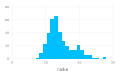

In [5]:
# Pour définir le nombre de bins
nbin = floor(sqrt(length(train.radius)))

# Pour régler les dimensions du graphique
set_default_plot_size(12cm, 8cm)

plot(train, x=:radius, Geom.histogram(bincount=nbin))  # avec un DataFrame

#plot(x=train.radius, Geom.histogram(bincount=nbin))  # avec un vecteur 

# Ici, on peut presque déjà apercevoir deux groupes, un autour de 12-13 et l'autre vers 18-20

### (b) Calculez la proportion de tumeurs malignes

In [6]:
# si maligne, train.diagnosis = 1
# si bénigne, train.diagnosis = 0

mean(train.diagnosis)  # version simple

0.37637362637362637

In [7]:
count(train.diagnosis .== 1) / length(train.diagnosis)  # La version longue

0.37637362637362637

### (c) Calculez la moyenne et l'écart-type du rayon en fonction de la classe de la tumeur

Vous pouvez utiliser les fonctions `groupby()` et `combine()`pour des opérations rapides.

In [8]:
df = combine(groupby(train, :diagnosis), # on groupe les données selon :diagnosis,
    
        :radius => mean => :moyenne,  # colonne radius, on calcule la moy. et on la passe dans une nouv. col.
       
        :radius => std => :ecarttype # puis on fait la même chose avec l'écart-type
    
     )

Row,diagnosis,moyenne,ecarttype
,Int64,Float64,Float64
1,0,12.1329,1.70878
2,1,17.5408,3.34649


### (d) Tracez des diagrammes en boîtes des rayons en fonction de la classe des tumeurs

Utilisez la géométrie `Geom.boxplot()` de *Gadfly.jl*.

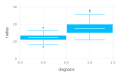

In [9]:
plot(train, x=:diagnosis, y=:radius,  Geom.boxplot())

# Exercice 2 - Modélisation du rayon par un mélange de lois

Modélisation du rayon des tumeurs (`:radius`) avec un mélange de lois de deux lois normales.



### (a) Estimez les paramètres du mélange de lois normales modélisant le rayon des tumeurs

Utilisez l'algorithme EM pour trouver les estimations du maximum de la vraisemblance.

Vous pouvez utiliser la fonction `GMMemfit()` fournie qui renvoie un objet de type `GMM` (aussi fourni).

In [10]:
fd = GMMemfit(train.radius)  # la fonction prend le vecteur des rayons en entrée

Convergence reached in 384 iterations


MixtureModel{Normal}(K = 2)
components[1] (prior = 0.6781): Normal{Float64}(μ=12.311686177548799, σ=1.7493231697959042)
components[2] (prior = 0.3219): Normal{Float64}(μ=18.078808102461252, σ=3.309706321993795)


### (b) Tracez le mélange de lois superposé à l'histogramme des données

Vouz pouvez utiliser la fonction `histplot()` fournie.

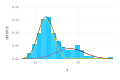

In [11]:
histplot(fd, train.radius)  # beau mélange de lois normales ici

### (c) Décrivez les composantes obtenues

**Note :** L'objet `GMM` est de type `UnivariateMixture` de la librairie *Distributions.jl*. On peut utiliser les méthodes standards de la librairie tel `pdf()` et `logpdf()` sur le type `UnivariateMixture`. Les méthodes suivantes sont particulières au type `UnivariateMixture` :
- `probs(fd::UnivariateMixture)` : retourne le vecteur des poids de chacune des composantes ;
- `component(fd::UnivariateMixture, k)` : retourne un objet de type `Distribution` correspondant à la composante k.

In [12]:
# Ici, la composante 1 a un poids de 68%  et la composante 2, 32%
probs(fd)

2-element Vector{Float64}:
 0.67807757136665
 0.3219224286333499

In [13]:
# Pour la composante 1, la moyenne et l'écart-type de la loi Normale sont :
component(fd, 1)

Normal{Float64}(μ=12.311686177548799, σ=1.7493231697959042)

In [14]:
# Pour la composante 2, la moyenne et l'écart-type de la loi Normale sont :
component(fd, 2)

Normal{Float64}(μ=18.078808102461252, σ=3.309706321993795)

### (d) Est-ce que les paramètres obtenus sont cohérents avec les questions (b) et (c) de l'exercice 1 ?

In [15]:
df  # Oui ! Ça ressemble beaucoup à ce qu'on avait obtenu....

Row,diagnosis,moyenne,ecarttype
,Int64,Float64,Float64
1,0,12.1329,1.70878
2,1,17.5408,3.34649


# Exercice 3 - Classification des tumeurs

Utilisation du mélange de lois pour classifier les tumeurs entre bénignes et malignes.

### (a) Calculez les probabilités que les observations proviennent de la 2e composante du mélange.

Calculez ces probabilités pour les observations des l'ensemble d'entraînement.

Vous pouvez utiliser la fonction `componentprob()` fournie pour calculer ces probabilités.

In [16]:
p = componentprob.(fd, train.radius, componentindex=2);

              #  ↑ . pour le faire sur tout le vecteur de rayons train.radius

In [17]:
p  # on obtient un vecteur de prob de 364 éléments 

364-element Vector{Float64}:
 0.12425192781776931
 0.07300092184379549
 0.07457600108737503
 0.9990534872114083
 0.9999999662318274
 0.1962922168106058
 0.37833304056384426
 0.03901084201598776
 0.0296752749303144
 0.053214527146159964
 0.1207231221740956
 0.09600302687305409
 0.07440178048235455
 ⋮
 0.07568681796254226
 0.051291742085550734
 0.24041913553903121
 0.040916966758626175
 0.0755859122836977
 0.03123884407380701
 0.12212925037713805
 0.8486387847204425
 0.09439562364213878
 0.32879551516479316
 0.05669968607502301
 0.9999970329847356

### (b) Prédisez les classes des tumeurs en fonction des probabilités calculées aux numéros précédents.

In [18]:
# j'initialise un vecteur de zéro de la même taille que le nombre de tumeurs (364)
ŷ = Int.(zeros(length(train.diagnosis))) ; 

# si la prob d'apartenir à la composant 2 est supérieure à 0.5, je classe la tumeur comme étant maligne
ŷ[p .> 0.5] .= 1 

98-element view(::Vector{Int64}, [4, 5, 16, 23, 25, 28, 31, 40, 42, 52  …  337, 338, 340, 341, 344, 345, 347, 349, 360, 364]) with eltype Int64:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

### (c) Calculez les qualités des prédictions obtenues

In [19]:
y = train.diagnosis  # le vrai diagnostic 

r = roc(y, ŷ)  # on calcule la ROC avec la fonction roc() de MLBase

ROCNums{Int64}
  p = 137
  n = 227
  tp = 94
  tn = 223
  fp = 4
  fn = 43


In [20]:
println("Sur l'ensemble d'entraînement")
println("- Nombre de tumeurs malignes bien identifiées : ",r.tp)
println("- Nombre de tumeurs bénignes bien identifiées : ",r.tn)
println("- Nombre de tumeurs malignes identifiées comme bénignes : ",r.fn)
println("- Nombre de tumeurs bénignes identifiées comme malignes : ",r.fp)
println("- Le score F₁ est de : ", round(f1score(r), digits=4))

Sur l'ensemble d'entraînement
- Nombre de tumeurs malignes bien identifiées : 94
- Nombre de tumeurs bénignes bien identifiées : 223
- Nombre de tumeurs malignes identifiées comme bénignes : 43
- Nombre de tumeurs bénignes identifiées comme malignes : 4
- Le score F₁ est de : 0.8


### (d) Répétez les étapes pour obtenir les prédictions sur l'ensemble de validation

In [21]:
# on calcule maitenant le prob d'appartenir à la composante 2 de fd (fitté sur train) avec les rayons de valid
p = componentprob.(fd, valid.radius, componentindex=2); 

In [22]:
# j'initialise un vecteur de zéro de la même taille que le nombre de tumeurs (de valid)
ŷ = Int.(zeros(length(valid.diagnosis)))  

# si la prob d'apartenir à la composant 2 est supérieure à 0.5, je classe la tumeur comme étant maligne
ŷ[p .> 0.5] .= 1 ;

In [23]:
y = valid.diagnosis  # le vrai diagnostic (de valid)

r = roc(y, ŷ)  # on calcule la ROC avec la fonction roc() de MLBase

ROCNums{Int64}
  p = 34
  n = 57
  tp = 25
  tn = 56
  fp = 1
  fn = 9


In [24]:
println("Sur l'ensemble d'entraînement")
println("- Nombre de tumeurs malignes bien identifiées : ",r.tp)
println("- Nombre de tumeurs bénignes bien identifiées : ",r.tn)
println("- Nombre de tumeurs malignes identifiées comme bénignes : ",r.fn)
println("- Nombre de tumeurs bénignes identifiées comme malignes : ",r.fp)
println("- Le score F₁ est de : ", round(f1score(r), digits=4))

Sur l'ensemble d'entraînement
- Nombre de tumeurs malignes bien identifiées : 25
- Nombre de tumeurs bénignes bien identifiées : 56
- Nombre de tumeurs malignes identifiées comme bénignes : 9
- Nombre de tumeurs bénignes identifiées comme malignes : 1
- Le score F₁ est de : 0.8333
